<a href="https://colab.research.google.com/github/yuhui-0611/contest/blob/main/Poverty_Prediction_Challenge_model_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X = pd.read_csv('/content/drive/MyDrive/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/contest/train_rates_gt.csv')

In [4]:
X_tr = pd.read_csv("/content/drive/MyDrive/contest/X_tr.csv")
X_val = pd.read_csv("/content/drive/MyDrive/contest/X_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/contest/X_test.csv")
y_tr = pd.read_csv("/content/drive/MyDrive/contest/y_tr.csv")
y_val = pd.read_csv("/content/drive/MyDrive/contest/y_val.csv")
test_id = pd.read_csv("/content/drive/MyDrive/contest/test_id.csv")
train = pd.read_csv("/content/drive/MyDrive/contest/train (3).csv")

In [5]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

**< 모델 입력에 필요한 최종 변수 >**

- X_tr
- X_val
- X_test
- y_tr
- y_val
- test_id

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

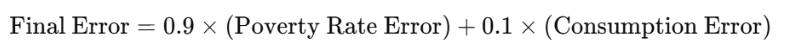

**< 범주형 분리 >**

In [6]:
cat_cols_tr = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
cat_cols_val = [c for c in X_val.columns if X_val[c].dtype == "object"]
cat_cols_test = [c for c in X_test.columns if X_test[c].dtype == "object"]

# **< Consumption Error >**

# CatBoost

In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [8]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [9]:
# 범주형 컬럼 인덱스
cat_features = [X_tr.columns.get_loc(c) for c in cat_cols_tr]

cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

0:	learn: 9.8621892	test: 9.6867693	best: 9.6867693 (0)	total: 199ms	remaining: 6m 37s
100:	learn: 6.1135566	test: 6.1285632	best: 6.1285632 (100)	total: 13.5s	remaining: 4m 12s
200:	learn: 5.8639792	test: 5.9610551	best: 5.9610551 (200)	total: 37.3s	remaining: 5m 34s
300:	learn: 5.7091712	test: 5.8872013	best: 5.8872013 (300)	total: 50.5s	remaining: 4m 44s
400:	learn: 5.5856236	test: 5.8480424	best: 5.8480424 (400)	total: 1m 3s	remaining: 4m 12s
500:	learn: 5.4930230	test: 5.8240401	best: 5.8240401 (500)	total: 1m 16s	remaining: 3m 47s
600:	learn: 5.4158328	test: 5.8037914	best: 5.8037914 (600)	total: 1m 28s	remaining: 3m 25s
700:	learn: 5.3520515	test: 5.7924029	best: 5.7923676 (699)	total: 1m 40s	remaining: 3m 7s
800:	learn: 5.2952179	test: 5.7853068	best: 5.7852087 (799)	total: 1m 52s	remaining: 2m 48s
900:	learn: 5.2344966	test: 5.7801738	best: 5.7797356 (880)	total: 2m 3s	remaining: 2m 30s
1000:	learn: 5.1880963	test: 5.7742331	best: 5.7742331 (1000)	total: 2m 16s	remaining: 2m 1

In [10]:
val_pred = cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
rmse

np.float64(5.763045018323956)

# LightGBM

In [11]:
# !pip install lightgbm

In [12]:
import lightgbm as lgb

In [13]:
X_tr_lgb   = X_tr.copy()
X_val_lgb  = X_val.copy()
X_test_lgb = X_test.copy()

for c in cat_cols_tr:
    X_tr_lgb[c]   = X_tr_lgb[c].astype("category")
    X_val_lgb[c]  = X_val_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")

In [14]:
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(
    X_tr_lgb, y_tr,
    eval_set=[(X_val_lgb, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 11.674833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1361]	valid_0's rmse: 5.78068	valid_0's l2: 33.4163


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=3000,
              objective='regression', random_state=42, subsample=0.8)

In [15]:
val_pred_lgb = lgb_model.predict(X_val_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
rmse_lgb

np.float64(5.78068376411244)

# XGBoost

In [16]:
from xgboost import XGBRegressor

In [17]:
X_tr_xgb   = X_tr.copy()
X_val_xgb  = X_val.copy()
X_test_xgb = X_test.copy()

In [18]:
cat_cols = X_tr_xgb.select_dtypes(include=["object"]).columns

for df in [X_tr_xgb, X_val_xgb, X_test_xgb]:
    df[cat_cols] = df[cat_cols].astype("category")

In [19]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=8000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",
    eval_metric="rmse",
    enable_categorical=True,
)

xgb_model.fit(
    X_tr_xgb, y_tr,
    eval_set=[(X_val_xgb, y_val)],
    verbose=50,
)

[0]	validation_0-rmse:9.78430
[50]	validation_0-rmse:6.60424
[100]	validation_0-rmse:6.08422
[150]	validation_0-rmse:5.93185
[200]	validation_0-rmse:5.86913
[250]	validation_0-rmse:5.83907
[300]	validation_0-rmse:5.81798
[350]	validation_0-rmse:5.80661
[400]	validation_0-rmse:5.79947
[450]	validation_0-rmse:5.79406
[500]	validation_0-rmse:5.78654
[550]	validation_0-rmse:5.78063
[600]	validation_0-rmse:5.77723
[650]	validation_0-rmse:5.77654
[700]	validation_0-rmse:5.77514
[750]	validation_0-rmse:5.77733
[800]	validation_0-rmse:5.77659
[850]	validation_0-rmse:5.77412
[900]	validation_0-rmse:5.77501
[950]	validation_0-rmse:5.77430
[1000]	validation_0-rmse:5.77620
[1050]	validation_0-rmse:5.78031
[1100]	validation_0-rmse:5.77811
[1150]	validation_0-rmse:5.77926
[1200]	validation_0-rmse:5.77981
[1250]	validation_0-rmse:5.78238
[1300]	validation_0-rmse:5.78379
[1350]	validation_0-rmse:5.78585
[1400]	validation_0-rmse:5.78587
[1450]	validation_0-rmse:5.78800
[1500]	validation_0-rmse:5.78862


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=8000,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
val_pred_xgb = xgb_model.predict(X_val_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
rmse_xgb

np.float64(5.909943571127902)

# **< Poverty Rate Error >**

# **1. LightGBM**

In [21]:
val_sid = val_df["survey_id"].astype(str).to_numpy()   # survey_id
val_true = np.asarray(y_val).reshape(-1)   # 실제 소비값
val_pred_lgb = val_pred_lgb.astype(np.float32)   # 예측 소비값
val_true = val_true.astype(np.float32)   # 실제 소비값

threshold 값(3.17, 3.94, …) 이 컬럼 이름 안에 존재

In [22]:
# y2에서 poverty rate 정답 컬럼만 선택
rate_cols = [c for c in y2.columns if c.startswith("pct_hh_below_")]

# 컬럼 이름에서 threshold 값만 추출 -> 오름차순 정렬
threshold = {c: float(c.split("pct_hh_below_")[1]) for c in rate_cols}
rate_cols_sorted = sorted(rate_cols, key=lambda c: threshold[c])

thresholds = np.array([threshold[c] for c in rate_cols_sorted], dtype=np.float32)

In [23]:
rate_cols

['pct_hh_below_3.17',
 'pct_hh_below_3.94',
 'pct_hh_below_4.60',
 'pct_hh_below_5.26',
 'pct_hh_below_5.88',
 'pct_hh_below_6.47',
 'pct_hh_below_7.06',
 'pct_hh_below_7.70',
 'pct_hh_below_8.40',
 'pct_hh_below_9.13',
 'pct_hh_below_9.87',
 'pct_hh_below_10.70',
 'pct_hh_below_11.62',
 'pct_hh_below_12.69',
 'pct_hh_below_14.03',
 'pct_hh_below_15.64',
 'pct_hh_below_17.76',
 'pct_hh_below_20.99',
 'pct_hh_below_27.37']

In [24]:
y2_map = {}

# y2를 survey 단위로 한 줄씩 읽음
for _, row in y2[["survey_id"] + rate_cols_sorted].iterrows():
    sid = str(int(row["survey_id"])) if str(row["survey_id"]).endswith(".0") else str(row["survey_id"])   # 해당 survey의 ID
    y2_map[sid] = row[rate_cols_sorted].to_numpy(dtype=np.float32)

In [25]:
val_pred_lgb = np.asarray(val_pred_lgb).astype(np.float32)
val_true_lgb = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_lgb = 0.0
poverty_cnt_lgb = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_lgb = val_pred_lgb[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_lgb = (pred_cons_lgb[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_lgb = np.abs(pr_pred_lgb - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb += float(ape_lgb.sum())
    poverty_cnt_lgb += ape_lgb.size

poverty_error_lgb = poverty_err_sum_lgb / poverty_cnt_lgb
print("Poverty Error (LGB):", poverty_error_lgb)

Poverty Error (LGB): 0.09794395848324425


In [26]:
cons_error_lgb = float(np.mean(np.abs(val_pred_lgb - val_true_lgb) / np.clip(val_true_lgb, 1e-6, None)))
print("Consumption Error (LGB):", cons_error_lgb)

Consumption Error (LGB): 0.3127005994319916


### Final Error

In [27]:
final_error_lgb = 0.9 * poverty_error_lgb + 0.1 * cons_error_lgb
print("Final Error (LGB):", final_error_lgb)

Final Error (LGB): 0.11941962257811899


## **1) log**

In [28]:
y_tr_log  = np.log1p(y_tr)
y_val_log = np.log1p(y_val)

In [29]:
lgb_model_log = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model_log.fit(
    X_tr_lgb, y_tr_log,
    eval_set=[(X_val_lgb, y_val_log)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

val_pred_lgb_log = lgb_model_log.predict(X_val_lgb)
val_pred_lgb2 = np.expm1(val_pred_lgb_log)
val_pred_lgb2 = np.maximum(val_pred_lgb2, 0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 2.328690
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1655]	valid_0's rmse: 0.307555	valid_0's l2: 0.09459


In [30]:
rmse_lgb_log = np.sqrt(mean_squared_error(y_val, val_pred_lgb2))
rmse_lgb_log

np.float64(5.830177574912352)

In [31]:
val_pred_lgb2 = np.asarray(val_pred_lgb2).astype(np.float32)
val_true_lgb2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_lgb2 = 0.0
poverty_cnt_lgb2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_lgb2 = val_pred_lgb2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_lgb2 = (pred_cons_lgb2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_lgb2 = np.abs(pr_pred_lgb2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb2 += float(ape_lgb2.sum())
    poverty_cnt_lgb2 += ape_lgb2.size

poverty_error_lgb2 = poverty_err_sum_lgb2 / poverty_cnt_lgb2
print("Poverty Error (LGB):", poverty_error_lgb2)

Poverty Error (LGB): 0.05445876247004459


In [32]:
cons_error_lgb2 = float(np.mean(np.abs(val_pred_lgb2 - val_true_lgb2) / np.clip(val_true_lgb2, 1e-6, None)))
print("Consumption Error (LGB):", cons_error_lgb2)

Consumption Error (LGB): 0.2831544578075409


### Final Error

In [33]:
final_error_lgb2 = 0.9 * poverty_error_lgb2 + 0.1 * cons_error_lgb2
print("Final Error (LGB):", final_error_lgb2)

Final Error (LGB): 0.07732833200379421


### Submisson

In [34]:
# log 스케일 예측
test_pred_log = lgb_model_log.predict(X_test_lgb)

# 원래 스케일로 복원
test_pred_1 = np.expm1(test_pred_log)

# 음수 방지 (필수)
test_pred_1 = np.maximum(test_pred_1, 0)

In [35]:
test_id.head()

,survey_id,hhid
0,400000,400001
1,400000,400002
2,400000,400003
3,400000,400004
4,400000,400005


In [36]:
test_sid = test_id["survey_id"].to_numpy()
test_hhid = test_id["hhid"].to_numpy()

In [37]:
submission_cons = pd.DataFrame({
    "survey_id": test_sid,
    "hhid": test_hhid,
    "cons_ppp17": test_pred_1
})

In [38]:
submission_cons.to_csv("predicted_household_consumption.csv", index=False)

# 첫 줄 확인
with open("predicted_household_consumption.csv", "r") as f:
    for _ in range(3):
        print(f.readline().strip())

survey_id,hhid,cons_ppp17
400000,400001,10.629973046059515
400000,400002,7.031735899201522


In [39]:
# survey_id별 poverty rate 계산
pov_rows = []
for sid in np.unique(test_sid):
    mask = (test_sid == sid)
    cons = test_pred_1[mask]

    # 각 threshold에 대해 비율 계산: mean(cons < threshold)
    # cons: (n,), thresholds: (k,) -> (k,)
    rates = (cons[:, None] < thresholds[None, :]).mean(axis=0)

    row = {"survey_id": sid}
    for c, r in zip(rate_cols_sorted, rates):
        row[c] = float(r)
    pov_rows.append(row)

submission_pov = pd.DataFrame(pov_rows, columns=["survey_id"] + rate_cols_sorted)
submission_pov.to_csv("predicted_poverty_distribution.csv", index=False)

# 첫 줄 확인
with open("predicted_poverty_distribution.csv", "r") as f:
    for _ in range(2):
        print(f.readline().strip())

survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
400000,0.02028063069579054,0.05953999710690004,0.11476927527846087,0.175206133371908,0.23277882250831766,0.2847099667293505,0.3348763199768552,0.38703891219441633,0.4416606393750904,0.4939968175900477,0.5410675538839866,0.590047736149284,0.6394040214089397,0.6878055836829162,0.74213800086793,0.794242731086359,0.8455663243165051,0.8986547085201794,0.9536525386952119


# **2. XGBoost**

In [40]:
xgb_model_log = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    enable_categorical=True,
    random_state=42,
)

xgb_model_log.fit(
    X_tr_xgb,
    y_tr_log,
    eval_set=[(X_val_xgb, y_val_log)],
    verbose=False,
)

val_pred_xgb_log = xgb_model_log.predict(X_val_xgb)
val_pred_xgb2 = np.expm1(val_pred_xgb_log)
val_pred_xgb2 = np.maximum(val_pred_xgb2, 0)

In [41]:
rmse_xgb_log = np.sqrt(mean_squared_error(y_val, val_pred_xgb2))
rmse_xgb_log

np.float64(5.815833007765848)

In [42]:
val_pred_xgb2 = np.asarray(val_pred_xgb2).astype(np.float32)
val_true_xgb2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_xgb2 = 0.0
poverty_cnt_xgb2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_xgb2 = val_pred_xgb2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_xgb2 = (pred_cons_xgb2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_xgb2 = np.abs(pr_pred_xgb2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_xgb2 += float(ape_xgb2.sum())
    poverty_cnt_xgb2 += ape_xgb2.size

poverty_error_xgb2 = poverty_err_sum_xgb2 / poverty_cnt_xgb2
print("Poverty Error (XGB):", poverty_error_xgb2)

Poverty Error (XGB): 0.05043391177528783


In [43]:
cons_error_xgb2 = float(np.mean(np.abs(val_pred_xgb2 - val_true_xgb2) / np.clip(val_true_xgb2, 1e-6, None)))
print("Consumption Error (XGB):", cons_error_xgb2)

Consumption Error (XGB): 0.28388386964797974


In [44]:
final_error_xgb2 = 0.9 * poverty_error_xgb2 + 0.1 * cons_error_xgb2
print("Final Error (XGB):", final_error_xgb2)

Final Error (XGB): 0.07377890756255702


# **3. CatBoost**

In [45]:
val_pred = val_pred.astype(np.float32)   # 예측 소비값

In [46]:
val_pred = np.asarray(val_pred).astype(np.float32)
val_true = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum = 0.0
poverty_cnt = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons = val_pred[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred = (pred_cons[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape = np.abs(pr_pred - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum += float(ape.sum())
    poverty_cnt += ape.size

poverty_error = poverty_err_sum / poverty_cnt
print("Poverty Error (CB):", poverty_error)

Poverty Error (CB): 0.09444748727898848


In [47]:
cons_error = float(np.mean(np.abs(val_pred - val_true) / np.clip(val_true, 1e-6, None)))
print("Consumption Error (LGB):", cons_error)

Consumption Error (LGB): 0.31062254309654236


### Final Error

In [48]:
final_error = 0.9 * poverty_error + 0.1 * cons_error
print("Final Error (CB):", final_error)

Final Error (CB): 0.11606499286074387


## **1) log**

In [49]:
cb_model_log = CatBoostRegressor(
    loss_function="RMSE",
    iterations=3000,
    learning_rate=0.03,
    depth=6,
    subsample=0.8,
    random_seed=42,
    eval_metric="RMSE",
    verbose=100
)

cb_model_log.fit(
    X_tr, y_tr_log,
    eval_set=(X_val, y_val_log),
    cat_features=cat_features,
    use_best_model=True,
    early_stopping_rounds=100
)

val_pred_log = cb_model_log.predict(X_val)
val_pred2 = np.expm1(val_pred_log)
val_pred2 = np.maximum(val_pred2, 0)

0:	learn: 0.6126454	test: 0.6171482	best: 0.6171482 (0)	total: 146ms	remaining: 7m 17s
100:	learn: 0.3430133	test: 0.3505752	best: 0.3505752 (100)	total: 13.3s	remaining: 6m 22s
200:	learn: 0.3210849	test: 0.3292075	best: 0.3292075 (200)	total: 25.5s	remaining: 5m 54s
300:	learn: 0.3133654	test: 0.3218239	best: 0.3218239 (300)	total: 38s	remaining: 5m 40s
400:	learn: 0.3085339	test: 0.3175168	best: 0.3175168 (400)	total: 51.3s	remaining: 5m 32s
500:	learn: 0.3049653	test: 0.3149185	best: 0.3149185 (500)	total: 1m 6s	remaining: 5m 30s
600:	learn: 0.3023449	test: 0.3130885	best: 0.3130885 (600)	total: 1m 19s	remaining: 5m 15s
700:	learn: 0.3001704	test: 0.3117794	best: 0.3117794 (700)	total: 1m 31s	remaining: 5m 1s
800:	learn: 0.2984902	test: 0.3109187	best: 0.3109187 (800)	total: 1m 44s	remaining: 4m 46s
900:	learn: 0.2970313	test: 0.3103098	best: 0.3103098 (900)	total: 1m 57s	remaining: 4m 33s
1000:	learn: 0.2957173	test: 0.3097606	best: 0.3097606 (1000)	total: 2m 8s	remaining: 4m 16s


In [50]:
rmse_log = np.sqrt(mean_squared_error(y_val, val_pred2))
rmse_log

np.float64(5.797140326543541)

In [51]:
val_pred2 = np.asarray(val_pred2).astype(np.float32)
val_true2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum2 = 0.0
poverty_cnt2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons2 = val_pred2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred2 = (pred_cons2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape2 = np.abs(pr_pred2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum2 += float(ape2.sum())
    poverty_cnt2 += ape2.size

poverty_error2 = poverty_err_sum2 / poverty_cnt2
print("Poverty Error (CB):", poverty_error2)

Poverty Error (CB): 0.05434743981612356


In [52]:
cons_error2 = float(np.mean(np.abs(val_pred2 - val_true2) / np.clip(val_true2, 1e-6, None)))
print("Consumption Error (CB):", cons_error2)

Consumption Error (CB): 0.28112879395484924


### Final Error

In [53]:
final_error2 = 0.9 * poverty_error2 + 0.1 * cons_error2
print("Final Error (CB):", final_error2)

Final Error (CB): 0.07702557522999613


# 앙상블

In [54]:
def calc_errors(pred):
    """
    pred: 검증셋 소비 예측 (원래 스케일, 1차원)
    return: (poverty_error, cons_error, final_error)
    """
    pred = np.asarray(pred, dtype=np.float32)
    true = val_true.astype(np.float32)

    # 1) poverty error
    poverty_err_sum = 0.0
    poverty_cnt = 0

    for sid in np.unique(val_sid):
        gt_rates = y2_map.get(sid, None)
        if gt_rates is None:
            continue

        mask = (val_sid == sid)
        cons = pred[mask]  # 이 survey_id의 예측 소비값들

        # threshold별 예측 poverty rate
        # cons: (n,), thresholds: (k,) -> (k,)
        pr_pred = (cons[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)

        # GT와의 MAPE
        ape = np.abs(pr_pred - gt_rates) / np.clip(gt_rates, 1e-6, None)

        poverty_err_sum += float(ape.sum())
        poverty_cnt     += ape.size

    poverty_error = poverty_err_sum / poverty_cnt

    # 2) consumption error
    cons_error = float(
        np.mean(
            np.abs(pred - true) / np.clip(true, 1e-6, None)
        )
    )

    # 3) final error
    final_error = 0.9 * poverty_error + 0.1 * cons_error

    return poverty_error, cons_error, final_error

## LGB + XGB / XGB + CB / LGB + CB

In [55]:
pairs = {
    "LGB+XGB": (val_pred_lgb2, val_pred_xgb2),
    "LGB+CB" : (val_pred_lgb2, val_pred),
    "XGB+CB" : (val_pred_xgb2, val_pred),
}

alphas = np.linspace(0.0, 1.0, 21)  # 0.0 ~ 1.0, step 0.05

best_pair_results = {}

for name, (p1, p2) in pairs.items():
    best_fe = 1e9
    best_a  = None
    best_pe = None
    best_ce = None

    for a in alphas:
        pred_mix = a * p1 + (1.0 - a) * p2
        pe, ce, fe = calc_errors(pred_mix)
        if fe < best_fe:
            best_fe = fe
            best_a, best_pe, best_ce = a, pe, ce

    best_pair_results[name] = (best_a, best_pe, best_ce, best_fe)

print("=== Best 2-model ensembles ===")
for name, (a, pe, ce, fe) in best_pair_results.items():
    print(f"{name}: alpha={a:4.2f} | poverty={pe:.6f} | cons={ce:.6f} | final={fe:.6f}")

=== Best 2-model ensembles ===
LGB+XGB: alpha=0.05 | poverty=0.050437 | cons=0.283569 | final=0.073750
LGB+CB: alpha=0.90 | poverty=0.053234 | cons=0.284822 | final=0.076393
XGB+CB: alpha=0.90 | poverty=0.049841 | cons=0.285096 | final=0.073367


## LGB + XGB + CB

In [56]:
# 가중치 후보 (0, 0.1, 0.2, ..., 1.0)
ws = np.linspace(0.0, 1.0, 11)

results_3 = []

for w_lgb in ws:
    for w_xgb in ws:
        w_cb = 1.0 - w_lgb - w_xgb
        if w_cb < 0:   # 합이 1 넘어가면 스킵
            continue

        pred_mix = (
            w_lgb * val_pred_lgb2 +
            w_xgb * val_pred_xgb2 +
            w_cb  * val_pred
        )

        pe, ce, fe = calc_errors(pred_mix)
        results_3.append((w_lgb, w_xgb, w_cb, pe, ce, fe))

# final error 최소 조합 찾기
best_w_lgb, best_w_xgb, best_w_cb, best_pe, best_ce, best_fe = min(
    results_3, key=lambda x: x[5]
)

print("=== 3-model ensemble search ===")
for w_lgb, w_xgb, w_cb, pe, ce, fe in results_3:
    print(f"LGB={w_lgb:4.2f}, XGB={w_xgb:4.2f}, CB={w_cb:4.2f} | "
          f"poverty={pe:.6f}, cons={ce:.6f}, final={fe:.6f}")

print("\n>> Best weights:")
print(f"LGB={best_w_lgb:.3f}, XGB={best_w_xgb:.3f}, CB={best_w_cb:.3f}")
print("    poverty_error:", best_pe)
print("    cons_error   :", best_ce)
print("    final_error  :", best_fe)

=== 3-model ensemble search ===
LGB=0.00, XGB=0.00, CB=1.00 | poverty=0.094447, cons=0.310623, final=0.116065
LGB=0.00, XGB=0.10, CB=0.90 | poverty=0.089969, cons=0.306610, final=0.111633
LGB=0.00, XGB=0.20, CB=0.80 | poverty=0.085216, cons=0.302853, final=0.106979
LGB=0.00, XGB=0.30, CB=0.70 | poverty=0.080237, cons=0.299416, final=0.102155
LGB=0.00, XGB=0.40, CB=0.60 | poverty=0.075322, cons=0.296270, final=0.097417
LGB=0.00, XGB=0.50, CB=0.50 | poverty=0.069556, cons=0.293418, final=0.091942
LGB=0.00, XGB=0.60, CB=0.40 | poverty=0.063772, cons=0.290859, final=0.086481
LGB=0.00, XGB=0.70, CB=0.30 | poverty=0.057886, cons=0.288608, final=0.080958
LGB=0.00, XGB=0.80, CB=0.20 | poverty=0.052153, cons=0.286675, final=0.075605
LGB=0.00, XGB=0.90, CB=0.10 | poverty=0.049841, cons=0.285096, final=0.073367
LGB=0.00, XGB=1.00, CB=0.00 | poverty=0.050434, cons=0.283884, final=0.073779
LGB=0.10, XGB=0.00, CB=0.90 | poverty=0.089961, cons=0.306879, final=0.111653
LGB=0.10, XGB=0.10, CB=0.80 | po

### submisson

In [57]:
# 1. 각 모델의 log 스케일 예측
test_pred_lgb_log = lgb_model_log.predict(X_test_lgb)
test_pred_xgb_log = xgb_model_log.predict(X_test_xgb)
test_pred_cb_log  = cb_model_log.predict(X_test)

# 2. 원래 스케일로 복원 + 음수 방지
def back_transform(y_log):
    y = np.expm1(y_log)
    return np.maximum(y, 0)

test_pred_lgb2 = back_transform(test_pred_lgb_log)
test_pred_xgb2 = back_transform(test_pred_xgb_log)
test_pred_cb2  = back_transform(test_pred_cb_log)

In [58]:
best_w_lgb, best_w_xgb, best_w_cb, best_pe, best_ce, best_fe = min(
    results_3, key=lambda x: x[5]
)
# best_w_lgb=0.0, best_w_xgb=0.9, best_w_cb=0.1 으로 나온 상태

In [59]:
test_pred_mix = (
    best_w_lgb * test_pred_lgb2 +
    best_w_xgb * test_pred_xgb2 +
    best_w_cb  * test_pred_cb2
)

In [60]:
test_sid = test_id["survey_id"].to_numpy()
test_hhid = test_id["hhid"].to_numpy()

submission_cons = pd.DataFrame({
    "survey_id": test_sid,
    "hhid": test_hhid,
    "cons_ppp17": test_pred_mix
})

submission_cons.to_csv("predicted_household_consumption.csv", index=False)

with open("predicted_household_consumption.csv", "r") as f:
    for _ in range(3):
        print(f.readline().strip())

survey_id,hhid,cons_ppp17
400000,400001,10.910041924139453
400000,400002,7.372263292108211


In [61]:
# survey_id별 poverty rate 계산
pov_rows = []
for sid in np.unique(test_sid):
    mask = (test_sid == sid)
    cons = test_pred_mix[mask]

    # 각 threshold에 대해 비율 계산
    rates = (cons[:, None] < thresholds[None, :]).mean(axis=0)

    row = {"survey_id": sid}
    for c, r in zip(rate_cols_sorted, rates):
        row[c] = float(r)
    pov_rows.append(row)

submission_pov = pd.DataFrame(pov_rows, columns=["survey_id"] + rate_cols_sorted)
submission_pov.to_csv("predicted_poverty_distribution.csv", index=False)

with open("predicted_poverty_distribution.csv", "r") as f:
    for _ in range(2):
        print(f.readline().strip())

survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
400000,0.019904527701432084,0.06017647909735281,0.11398813829017793,0.17430927238536092,0.23303920150441199,0.2864458267033126,0.33484738897728916,0.387588601186171,0.44027195139592074,0.4918269926225951,0.5399681759004774,0.587617532185737,0.6352090264718646,0.6870244466946333,0.7407493128887603,0.79343266309851,0.8455373933169391,0.8979603645305946,0.9534500216982497
